<h1 style="text-align: center;">TP - Finer tuner BERT sur ces données pour en faire un classifier. </h1>


L'objectif de ce TP est de fine tuner BERT et de l'étendre pour faire une tâche de classification précise.   

Vous connaissz bien le jeu de données que nous allons utiliser :)   
Il s'agit des tweets scientifiques. Par contre nous n'allons nous intéresser qu'au premier niveau de classification ("science_related") et donc à une classification binaire (le tweet parle de science ou non).   

La première partie du TP est plus une partie observation/compréhension de BERT. Ne négligez pas les questions qui vous seront posées elles seront très utiles pour la suite du TP. Passez du temps pour bien comprendre. Les modèles de transformer ne sont pas simples. Il faut que vous compreniez bien les différents composants.



**Remarque.** BERT, développé par Google en 2018, est un encodeur de référence et de nouvelles variantes apparaissent régulièrement, comme par exemple [NEOBERT](https://arxiv.org/html/2502.19587v1).  
Le code des modèles est disponible sur GitHub ([BERT2018](https://github.com/google-research/bert)) et les poids pré-entraînés ainsi que les tokenizers (par exemple `bert-base-uncased`, `bert-large-uncased`) sont disponibles sur le [Hugging Face Hub](https://huggingface.co/docs/transformers/model_doc/bert).

Il existe de nombreuses variantes adaptées à une langue ou à un domaine comme par exemple :
- CamemBERT (français, archi RoBERTa), pré-entraîné sur OSCAR. [CamemBERT](XXX)
- FlauBERT (français, archi BERT), pré-entraîné sur un large corpus hétérogène. [FlauBERT](XXX)
- BioBERT (biomédical), pré-entraîné sur PubMed/PMC. [BioBERT](XXX)

Le tableau suivant vous donne un aperçu des ordres de grandeurs du nombre de paramètres de différents modèles :   

| Modèle      | Paramètres (≈) | Données de pré-entraînement (principales) |
|-------------|----------------:|--------------------------------------------|
| BERT-base   | 110 M           | BookCorpus + Wikipedia (EN)                |
| BERT-large  | 340 M           | BookCorpus + Wikipedia (EN)                |
| DistilBERT  | 66 M            | Distillation à partir de BERT-base         |
| CamemBERT   | ~110 M          | OSCAR (FR)                                 |
| FlauBERT    | tailles variées | Corpus FR hétérogène (Wikipedia, CCNet/OSCAR, …) |
| BioBERT     | ~110 M          | PubMed + PMC (biomédical)                  |

Sur Colab, BERT (110 M ou 340 M) est lourd aussi nous utiliserons plutôt DistilBERT qui est beaucoup plus léger.   

Pour information, DistilBERT a été obtenu par distillation, c'est à dire  on entraîne un petit modèle "élève" pour imiter un grand modèle “professeur”(BERT-base) pendant le pré-entraînement. Résultat, on a moins de paramètres, c'est plus rapide et les performances restent assez proches du modèle source. C'est comme cela qu'aurait d'ailleurs été appris Deepseek [DeepSeek-OpenAI](https://info.haas-avocats.com/droit-digital/openai-vs-deepseek-une-accusation-de-distillation-qui-fait-debat).


  

# A FAIRE EN TOUT PREMIER PREMIER

L'utilisation de BERT avec Google Colab pose des problèmes de versions !!! Les librairies évoluent sans cette et cela pose de vrais problèmes. **Il est impératif au tout début d'exécuter la cellule suivante et de redémarrer le noyau**

# Importation des librairies

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import pandas as pd
import re
import numpy as np
import random
import zipfile
import requests
import io
from pathlib import Path

import matplotlib.pyplot as plt
from IPython.display import Image, display

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.decomposition import PCA

import tensorflow as tf
import tf_keras as keras
from tf_keras import layers, Model
from tf_keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
tf.config.list_physical_devices('GPU')

from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertModel
from transformers import DistilBertConfig
from transformers import TFDistilBertForQuestionAnswering


2025-11-27 09:07:45.156885: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-27 09:07:45.175596: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764234465.202663    4714 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764234465.210329    4714 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-27 09:07:45.236462: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Un petit tour de BERT/DistilBERT

Avant de commencer à faire du fine tuning, nous allons déjà essayer de mieux comprendre le fonctionnement de BERT.

**Attention :**   
- ERT/DistilBERT sont des encodeurs entraînés avec comme objectif de prédire des tokens masqués au milieu de la phrase, en regardant à gauche et à droite. Ils ne peuvent donc pas prédire le prochain mot ou compléter une phrase comme le fait un modèle comme GPT qui est lui un décodeur. Si vous avez un doute regardez les différentes architectures des transformers.   
- Au-delà du modèle général, il existe des variantes BERT/DistilBERT déjà adaptées à des tâches comme la question-réponse ([SQuAD](https://rajpurkar.github.io/SQuAD-explorer/), [FQuAD](https://fquad.github.io/)), la classification ([Allociné](https://huggingface.co/datasets/allocine), [SST-2](https://huggingface.co/datasets/glue/viewer/sst2/train)), le NER ([CoNLL-2003](https://huggingface.co/datasets/conll2003), modèles FR comme [CamemBERT NER](https://huggingface.co/Jean-Baptiste/camembert-ner)), ou des domaines spécialisés ([BioBERT](https://arxiv.org/abs/1901.08746)). Dans cette section, nous en testerons une en QA pour voir le fonctionnement général.


## Au départ les tokens

Le point de départ des modèles sont des textes qui sont transformés en tokens. Ici nous utiliserons `DistilBertTokenizerFast` qui a déjà été entraîné et est disponible dans `distilbert-base-uncased`.   
L'idée est donc tout simplement de charger le tokenizer appris et après de l'utiliser pour "tokenizer" des phrases.
Le code suivant permet de tokenizer vos phrases :

```python
enc = tok(texts, padding=False, truncation=True)
```
On applique la fonction du tokenizer sur nos textes. `padding=False`  indique qu'on ne rajoute rien pour égaliser les longueurs des séquences (chaque phrase garde sa longueur propre). `truncation=True` indique simplement que si une phrase dépasse la longueur maximale autorisée par le modèle (par défaut la longueur interne du tokenizer), elle sera coupée à cette longueur plutôt que de provoquer une erreur.



Essayez quelques exemples de textes pour voir ce que cela donne. L'exemple que vous avez est très simple et le résultat assez attendu, alors testez avec de longs mots, avec de longues phrases, avec des emojis et surtout regardez bien comment les tokens sont créés (leur découpage) et la valeur qu'ils ont. C'est important de bien comprendre cette tokenization qui n'est pas forcément courante.  

Question subsidiaire : à votre avis si on veut fine tuner un modèle est ce qu'on est obligé de charger un tokenizer appris ?

In [2]:
tok = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

######## ESSAYER PLUSIEURS PHRASES ET BIEN REGARDER LA SORTIE DU MODELE
texts = [
    "Alice sees the white rabbit"
]
enc = tok(texts, padding=False, truncation=True)
for t, ids in zip(texts, enc["input_ids"]):
    print("\n", t)
    print(tok.convert_ids_to_tokens(ids))
    print("ids:", ids)
    print("decoded:", tok.decode(ids))


 Alice sees the white rabbit
['[CLS]', 'alice', 'sees', 'the', 'white', 'rabbit', '[SEP]']
ids: [101, 5650, 5927, 1996, 2317, 10442, 102]
decoded: [CLS] alice sees the white rabbit [SEP]


Allons un peu plus loin sur cette histoire de padding. Regardez le résultat de l'exécution de la cellule suivante.

In [4]:
tok = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

short = "Alice sees"
long  = "Alice sees the white rabbit"
texts = [short, long]
enc_var = tok(texts, padding=False, truncation=False)
print("Sans padding:")
for i, ids in enumerate(enc_var["input_ids"]):
    print("phrase ", i, "longueur :", len(ids), "decoded", tok.decode(ids))

Sans padding:
phrase  0 longueur : 4 decoded [CLS] alice sees [SEP]
phrase  1 longueur : 7 decoded [CLS] alice sees the white rabbit [SEP]


Maintenant on va mettre du padding. On relance le tokenizer sur le texte que l'on stocke dans une variable `enc_auto` qui est un dictionnaire. Affichez le type de  `enc_auto` et ses clés. Regardez bien les print

In [5]:
enc_auto = tok(texts, padding=True, truncation=False)

# Afficher ici le type de enc_auto et les clés associés

# A COMPLETER
print ("Le type de enc_auto", type(enc_auto))
print ("Les différentes clés ", )

print("\nPadding=True (longueur = longueur du plus long):")
print("input_ids[0]:", enc_auto["input_ids"][0])
print("attention_mask[0]:", enc_auto["attention_mask"][0])
print("input_ids[1]:", enc_auto["input_ids"][1])
print("attention_mask[1]:", enc_auto["attention_mask"][1])

Le type de enc_auto <class 'transformers.tokenization_utils_base.BatchEncoding'>
Les différentes clés 

Padding=True (longueur = longueur du plus long):
input_ids[0]: [101, 5650, 5927, 102, 0, 0, 0]
attention_mask[0]: [1, 1, 1, 1, 0, 0, 0]
input_ids[1]: [101, 5650, 5927, 1996, 2317, 10442, 102]
attention_mask[1]: [1, 1, 1, 1, 1, 1, 1]


et voilà vous voyez il y a une clé qui s'appelle `attention_mask` et voilà le padding va en fait remplir les valeurs 1 quand une valeur existe et 0 si elle n'existe pas.   

**Attention :** l'exemple est donné pour illustration, en réalité on utilisera une valeur `max_length` pour que toutes les séquences  aient la même longueur bien sûr.

## On sort les masques

Maintenant nous allons examiner un peu plus attentivement ce `attention_mask`.

In [6]:
tok = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

texts=["Alice was sleeping.",
"Alice sees the white rabbit."]

enc = tok(texts, padding="max_length", truncation=True, max_length=12)
for t, ids in zip(texts, enc["input_ids"]):
    print("\n", t)
    print(tok.convert_ids_to_tokens(ids))
    print("ids:", ids)
    print("decoded:", tok.decode(ids))


 Alice was sleeping.
['[CLS]', 'alice', 'was', 'sleeping', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
ids: [101, 5650, 2001, 5777, 1012, 102, 0, 0, 0, 0, 0, 0]
decoded: [CLS] alice was sleeping. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

 Alice sees the white rabbit.
['[CLS]', 'alice', 'sees', 'the', 'white', 'rabbit', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
ids: [101, 5650, 5927, 1996, 2317, 10442, 1012, 102, 0, 0, 0, 0]
decoded: [CLS] alice sees the white rabbit. [SEP] [PAD] [PAD] [PAD] [PAD]


Exécutez la cellule suivante. Vous n'avez pas besoin d'essayer de comprende le code. Que constatez vous sur le modèle affiché ?

In [13]:
backbone = TFDistilBertModel.from_pretrained("distilbert-base-uncased",
                                             from_pt=True)

MAX_LEN = 12
ids  = layers.Input(shape=(MAX_LEN,), dtype="int32", name="input_ids")
mask = layers.Input(shape=(MAX_LEN,), dtype="int32", name="attention_mask")

h = backbone({"input_ids": ids, "attention_mask": mask}).last_hidden_state
probe = Model(inputs=[ids, mask], outputs=h, name="distilbert_probe")

model_dir = "./figs"; os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, "distilbert_probe.png")

keras.utils.plot_model(
    probe, model_path,
    show_shapes=True, show_dtype=True, show_layer_names=True,
    expand_nested=True, rankdir="BT", show_layer_activations=True
)

# display(Image(filename=model_path))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Et oui les modèles BERT/DistillBERT ont deux entrées. `input_ids` correspond à un tableau des identifiant des phrases tokenizées et `association_mask` est un tableau des masques associés.  

La cellule suivante illustre comment utiliser le modèle en lui donnant un batch composé de deux entrées. Regardez bien les entrées. Est-ce cohérent ? et regardez aussi la sortie, est-ce que c'est cohérent avec le schéma obtenu ci-dessus.

In [15]:
model = TFDistilBertModel.from_pretrained("distilbert-base-uncased",
                                          from_pt=True)

# Il est nécessaire de convertir en tenseur pour l'utiliser
batch = {
    "input_ids": tf.convert_to_tensor(enc["input_ids"]),
    "attention_mask": tf.convert_to_tensor(enc["attention_mask"]),
}

out = model(batch)

print ("Les masques input_id et les masques en entrée du modèle \n")

print("input_ids[0] : ", batch["input_ids"][0].numpy(),
      "attention_mask[0] :", batch["attention_mask"][0].numpy())
print("input_ids[1] : ", batch["input_ids"][1].numpy(),
      "attention_mask[1] :", batch["attention_mask"][1].numpy())

print("\nlast_hidden_state shape:", out.last_hidden_state.shape)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Les masques input_id et les masques en entrée du modèle 

input_ids[0] :  [ 101 5650 2001 5777 1012  102    0    0    0    0    0    0] attention_mask[0] : [1 1 1 1 1 1 0 0 0 0 0 0]
input_ids[1] :  [  101  5650  5927  1996  2317 10442  1012   102     0     0     0     0] attention_mask[1] : [1 1 1 1 1 1 1 1 0 0 0 0]

last_hidden_state shape: (2, 12, 768)


Normalement vous devriez voir : `last_hidden_state shape: (2, 12, 768)`. Quelques explications : si on regarde la sortie du modèle DistillBERT (voir schéma du modèle) on constate qu'effectivement c'est cohérent avec la sortie. En fait le `2`correspond au nombre d'entrées dans le batch (ici nous avons deux phrases). Le `12` correspond à `max_length` et le `768` correspond au `hidden_size` c'est à dire la dimension des vecteurs internes de DistilBERT (768 pour distilbert-base-*).  

En fait l'intuition derrière est que pour chaque phrase du batch et pour chaque position (jusqu'à 12 tokens), le modèle renvoie un vecteur de 768.  

Pour vous faire une idée, essayons de regarder à quoi correspond le vecteur pour le token correspondant à Alice. Attention, il a été tokénizé donc il est en minuscule, on doit donc chercher 'alice' et regarder à quel numéro de token il correspond.

In [16]:
print ("Les numéros de tokens de la première phrase")
print (batch["input_ids"][0].numpy())

print ("La correspondance id - token")
tokens0 = tok.convert_ids_to_tokens(batch["input_ids"][0].numpy())  # phrase 0
print(tokens0)

# on cherche 'alice' (il a été converti en minuscule)
idx = tokens0.index('alice')
vec_alice = out.last_hidden_state[0, idx, :].numpy()
print("Index 'alice' (phrase 0):", idx, " - vec shape:", vec_alice.shape)

Les numéros de tokens de la première phrase
[ 101 5650 2001 5777 1012  102    0    0    0    0    0    0]
La correspondance id - token
['[CLS]', 'alice', 'was', 'sleeping', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
Index 'alice' (phrase 0): 1  - vec shape: (768,)


et maintenant si on veut voir à quoi correspond le vecteur associé à 'alice' :

In [ ]:
print (vec_alice)

## Et les embeddings ?

Il y a deux 'alice' dans deux phrases différentes. Comparons un peu les débuts des vecteurs de sortie pour la phrase 1 et la phrase 2.

In [17]:
print("Les numéros de tokens de la première phrase")
print(batch["input_ids"][0].numpy())

print("La correspondance id - token (phrase 1)")
tokens0 = tok.convert_ids_to_tokens(batch["input_ids"][0].numpy())
print(tokens0)

# on cherche 'alice' (minuscule car modèle uncased)
idx0 = tokens0.index('alice')
vec_alice_p1 = out.last_hidden_state[0, idx0, :].numpy()
print("Index 'alice' (phrase 1): ",idx0, " - vec shape :",vec_alice_p1.shape)

print("\nLes numéros de tokens de la deuxième phrase")
print(batch["input_ids"][1].numpy())

print("La correspondance id - token (phrase 2)")
tokens1 = tok.convert_ids_to_tokens(batch["input_ids"][1].numpy())
print(tokens1)

idx1 = tokens1.index('alice')
vec_alice_p2 = out.last_hidden_state[1, idx1, :].numpy()
print("Index 'alice' (phrase 2):",idx1, " - vec shape :",vec_alice_p2.shape)


Les numéros de tokens de la première phrase
[ 101 5650 2001 5777 1012  102    0    0    0    0    0    0]
La correspondance id - token (phrase 1)
['[CLS]', 'alice', 'was', 'sleeping', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
Index 'alice' (phrase 1):  1  - vec shape : (768,)

Les numéros de tokens de la deuxième phrase
[  101  5650  5927  1996  2317 10442  1012   102     0     0     0     0]
La correspondance id - token (phrase 2)
['[CLS]', 'alice', 'sees', 'the', 'white', 'rabbit', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
Index 'alice' (phrase 2): 1  - vec shape : (768,)


Nous avons déjà vu qu'une bonne manière de comparer des vecteurs est la similarité cosinus :

In [18]:
cos = float(np.dot(vec_alice_p1, vec_alice_p2) /
            (np.linalg.norm(vec_alice_p1) * np.linalg.norm(vec_alice_p2) + 1e-9))
print(f"\nSimilarité cosinus entre 'Alice' (phrase 1 vs 2): {cos:.3f}")


Similarité cosinus entre 'Alice' (phrase 1 vs 2): 0.904


Surpris du résultat ? Est-ce qu'on est sûr qu'on parle de la même 'alice' ? déjà on peut véfifier qu'on a le même identifiant.

In [19]:
# Vérifier que c’est le même id de token pour 'alice' dans les deux phrases
id_p1 = int(batch["input_ids"][0, idx0].numpy())
id_p2 = int(batch["input_ids"][1, idx1].numpy())
print("\nId du token 'alice' (phrase 1) :", id_p1)
print("Id du token 'alice' (phrase 2) :", id_p2)
print("Est-ce le même id ? ", id_p1 == id_p2)

print("Token pour id_p1 :", tok.convert_ids_to_tokens([id_p1])[0])
print("Token pour id_p2 :", tok.convert_ids_to_tokens([id_p2])[0])


Id du token 'alice' (phrase 1) : 5650
Id du token 'alice' (phrase 2) : 5650
Est-ce le même id ?  True
Token pour id_p1 : alice
Token pour id_p2 : alice


Donc oui on parle de la même alice. Le numéro du token est le même.   

Examinons ça un peu plus en détail ... Juste après la couche d'entrée dans les transformers il y a une couche d'embeddings. Regardons un peu ce qu'elle contient ?

In [20]:
print("tokens phrase 1:", tok.convert_ids_to_tokens(batch["input_ids"][0].numpy()))
print("tokens phrase 2:", tok.convert_ids_to_tokens(batch["input_ids"][1].numpy()))

idx0 = tokens0.index('alice')
idx1 = tokens1.index('alice')

print("idx0 - token alice dans la phrase 1 ",
      idx0,", idx1 - token alice dans phrase 2 :", idx1)
id_p1 = int(batch["input_ids"][0, idx0].numpy())
id_p2 = int(batch["input_ids"][1, idx1].numpy())
print("token_id d'alice dans la phrase1:",
      id_p1, " -  token_id d'alice dans la phrase2:", id_p2)

# Récupération de la matrice d'embedding de mot (statique)
we = model.get_input_embeddings()
emb_batch = we(batch["input_ids"])
vec_emb_alice_p1 = emb_batch[0, idx0, :].numpy()
vec_emb_alice_p2 = emb_batch[1, idx1, :].numpy()

print("vec_emb_alice_p1 shape:", vec_emb_alice_p1.shape)
print("vec_emb_alice_p2 shape:", vec_emb_alice_p2.shape)

tokens phrase 1: ['[CLS]', 'alice', 'was', 'sleeping', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
tokens phrase 2: ['[CLS]', 'alice', 'sees', 'the', 'white', 'rabbit', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
idx0 - token alice dans la phrase 1  1 , idx1 - token alice dans phrase 2 : 1
token_id d'alice dans la phrase1: 5650  -  token_id d'alice dans la phrase2: 5650
vec_emb_alice_p1 shape: (768,)
vec_emb_alice_p2 shape: (768,)


et si on compare avec un cosinus on obtient :

In [21]:
cos = float(np.dot(vec_emb_alice_p1, vec_emb_alice_p2) /
            (np.linalg.norm(vec_emb_alice_p1) * np.linalg.norm(vec_emb_alice_p2) + 1e-9))
print(f"\nSimilarité cosinus entre 'Alice' (phrase 1 vs 2) en entrée du modèle : {cos:.3f}")


Similarité cosinus entre 'Alice' (phrase 1 vs 2) en entrée du modèle : 1.000


En entrée pour les embeddings on a une similarité cosinus = 1. C'est le même vecteur. En sortie on a une similarité cosinus différente de 1. Ce sont donc deux vecteurs différents. Si vous avez compris pourquoi vous avez compris le rôle des transformeurs :) si vous n'avez pas compris relisez vos cours et les guides qui vous ont été donnés !!!     

C'est tout ça la puissance d'un transformer c'est de pouvoir tenir compte du contexte : alice dans 'Alice was sleeping.' n'aura pas exactement la même représentation que alice dans 'Alice sees the white rabbit". Les embeddings en entrée correspondent au vocabulaire de base, ils sont justement transformés en passant par les couches d'atttention avec de prendre en compte le contexte.

Pour finir de vous en convaincre, exécutez la cellule suivante qui effectue une ACP sur les embeddings. Comparez les différents plots pour voir la différence.

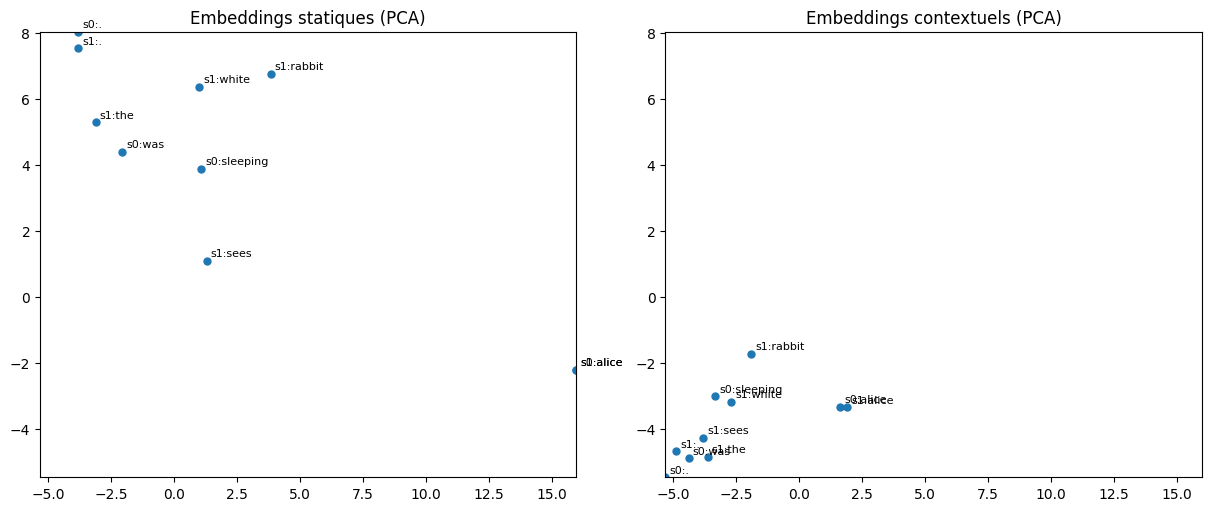

In [22]:
we = model.get_input_embeddings()
emb_batch = we(batch["input_ids"])
specials = {"[PAD]", "[CLS]", "[SEP]"}
X_static, X_context, labels = [], [], []

B, L = batch["input_ids"].shape
for i in range(B):
    ids_i = batch["input_ids"][i].numpy()
    toks_i = tok.convert_ids_to_tokens(ids_i)
    for j, tj in enumerate(toks_i):
        if tj in specials:
            continue
        X_static.append(emb_batch[i, j, :].numpy())
        X_context.append(out.last_hidden_state[i, j, :].numpy())
        labels.append(f"s{i}:{tj}")

X_static = np.vstack(X_static)
X_context = np.vstack(X_context)

pca = PCA(n_components=2, random_state=42)
X_all_2d = pca.fit_transform(np.vstack([X_static, X_context]))
n = X_static.shape[0]
X_static_2d = X_all_2d[:n]
X_context_2d = X_all_2d[n:]


xmin = np.min(np.vstack([X_static_2d[:,0], X_context_2d[:,0]]))
xmax = np.max(np.vstack([X_static_2d[:,0], X_context_2d[:,0]]))
ymin = np.min(np.vstack([X_static_2d[:,1], X_context_2d[:,1]]))
ymax = np.max(np.vstack([X_static_2d[:,1], X_context_2d[:,1]]))

fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

axes[0].scatter(X_static_2d[:, 0], X_static_2d[:, 1], s=25)
axes[0].set_title("Embeddings statiques (PCA)")
axes[0].set_xlim(xmin, xmax); axes[0].set_ylim(ymin, ymax)
for (x, y), lab in zip(X_static_2d, labels):
    axes[0].annotate(lab, (x, y), fontsize=8, xytext=(3, 3), textcoords="offset points")

axes[1].scatter(X_context_2d[:, 0], X_context_2d[:, 1], s=25)
axes[1].set_title("Embeddings contextuels (PCA)")
axes[1].set_xlim(xmin, xmax); axes[1].set_ylim(ymin, ymax)
for (x, y), lab in zip(X_context_2d, labels):
    axes[1].annotate(lab, (x, y), fontsize=8, xytext=(3, 3), textcoords="offset points")

plt.show()

La cellule suivante illustre, pour le token 'alice', la distribution d'attention sur tous les tokens de la phrase, couche par couche, pour la phrase 1 à gauche et la phrase 2 à droite. Bien sûr les phrases sont courtes et assez proches et on a vu que la similarité cosinus est à peu près 0.904 la similarité des vecteurs reste très proche au fur et à mesure des couches. Par contre si on regarde attentivement les plots on pourra constater une très légère différence et notamment sur la dernière couche.

In [ ]:
out_att = model(batch, output_attentions=True)
atts = out_att.attentions
num_layers = len(atts)

tokens0 = tok.convert_ids_to_tokens(batch["input_ids"][0].numpy())
tokens1 = tok.convert_ids_to_tokens(batch["input_ids"][1].numpy())
a0 = tokens0.index('alice')
a1 = tokens1.index('alice')

mats0, mats1 = [], []
for l in range(num_layers):
    A0 = atts[l][0].numpy().mean(axis=0)
    A1 = atts[l][1].numpy().mean(axis=0)
    mats0.append(A0); mats1.append(A1)

vmax = np.quantile(np.concatenate([m.ravel() for m in (mats0+mats1)]), 0.95)
fig, axes = plt.subplots(num_layers, 2, figsize=(10, 2.8*num_layers),
                         constrained_layout=True)

for l in range(num_layers):
    for col, (A, tokens, a_idx, title) in enumerate([
        (mats0[l], tokens0, a0, "Phrase 1"),
        (mats1[l], tokens1, a1, "Phrase 2"),
    ]):
        ax = axes[l, col] if num_layers > 1 else axes[col]
        im = ax.imshow(A, vmin=0, vmax=vmax, interpolation="nearest")
        ax.set_title(f"Couche {l} — {title}")
        ax.set_xticks(range(len(tokens))); ax.set_xticklabels(tokens,
                                                              rotation=90,
                                                              fontsize=8)
        ax.set_yticks(range(len(tokens))); ax.set_yticklabels(tokens,
                                                              fontsize=8)
        ax.set_xlabel("clé (key)"); ax.set_ylabel("requête (query)")
        ax.axhline(a_idx-0.5, color='r'); ax.axhline(a_idx+0.5, color='r')
        ax.axvline(a_idx-0.5, color='r'); ax.axvline(a_idx+0.5, color='r')

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.85)
cbar.set_label("poids d'attention (softmax par ligne)")

plt.show()

## Et si on revenait sur les tokens ...

Si vous avez bien essayé de changer de phrases précédemment vous avez constaté que le texte n'est pas découpé en mots entiers mais en sous-mots. En plus, un mot entier peut devenir plusieurs sous-tokens.  Si par exemple vous revenez en arrière et que vous essayez  "Emmanuel Macron" vous obtiendrez :
```python
['[CLS]', 'emmanuel', 'macro', '##n', '[SEP]']  
```
le préfixe `##` indique tout simplement qu'un sous-token est la suite d'un mot déjà commencé (ici 'macro', '##n' pour "macron"). On découpe les mots en morceaux fréquents pour limiter la taille du vocabulaire : ainsi, même un mot rare ou nouveau peut être représenté en combinant ces morceaux (par exemple 'macro' + '##n').

BERT/DistilBERT utilisent bien entendu des tokens particuliers :

- `[CLS]` : inséré au début d'une séquence. Ce token est très important car il est souvent utilisé comme un "résumé" de la séquence pour des tâches comme la classification.
- `[SEP]` : séparateur de segments et marqueur de fin de séquence.
- `[PAD]` : remplissage pour obtenir des lots de séquences de même longueur (ignoré par l'attention via le masque). Nous avons eu l'occasion de le voir précédemment
- `[MASK]` : utilisé pendant le pré-entraînement (MLM) pour demander au modèle de prédire un token manquant. Pour l'instant nous ne l'avons pas encore vu ... mais cela va arrivé
- `[UNK]` : token “inconnu” quand un symbole n'est pas dans le le vocabulaire. Par exemple si précédemment vous avez mis des emojis ou des mots peu utilisés, vous vous êtes peut être rendu compte que le modèle ne les connaissait pas.


## Et au final comment on résume la séquence si on veut faire de la classification ?

Si on a envie de faire de la classification, par exemple dire que "Alice sees the white rabbit" est positive. Si on regarde en entrée après la tokenisation  on va avoir :   
```python
['[CLS]', 'alice', 'sees', 'the', 'white', 'rabbit', '[SEP]']
ids: [101, 5650, 5927, 1996, 2317, 10442, 102]
```   

Nous avons vu précédemment que pour alice avec son id=5650 on obtenait en sortie un vecteur de dimension 768 qui représentait l'embedding contextuel d'alice. Maintenant qu'est ce qui se passe si je donne en entrée les tokens de la phrase.

In [23]:
text = ["Alice sees the white rabbit"]
b = tok(text, padding=False, truncation=True, return_tensors="tf")

model = TFDistilBertModel.from_pretrained("distilbert-base-uncased",
                                          from_pt=True)

out = model(b)
H = out.last_hidden_state[0]
print("last_hidden_state shape:", out.last_hidden_state.shape)
print("H shape:", H.shape)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


last_hidden_state shape: (1, 7, 768)
H shape: (7, 768)


Jusque là c'est cohérent par rapport à ce qu'on a vu précédemment. `last_hidden_state shape: (1, 7, 768)` indique bien qu'on a 1 batch. Le 7 c'est parce qu'on a enlevé le padding lors de la tokenization et donc on retrouve bien les 5 mots de la phrase plus les 2 tokens spéciaux. Le 768 indique la taille de l'embeddings. Mais de quel embedding parlons nous ?

In [26]:
tokens = tok.convert_ids_to_tokens(b["input_ids"][0].numpy())

print("Tokens et tailles des vecteurs (hors CLS/SEP) :")
for i, t in enumerate(tokens):
    if t not in ("[CLS]", "[SEP]"):
      print("position=",i," - token='", t, "' - shape =", H[i].shape)

Tokens et tailles des vecteurs (hors CLS/SEP) :
position= 1  - token=' alice ' - shape = (768,)
position= 2  - token=' sees ' - shape = (768,)
position= 3  - token=' the ' - shape = (768,)
position= 4  - token=' white ' - shape = (768,)
position= 5  - token=' rabbit ' - shape = (768,)


Le 768 indique bien la taille des vecteurs associés à chacun des tokens de la phrase. Donc jusque là c'est cohérent avec ce qu'on a vu. Mais qu'est-ce qu'il y a dans `CLS` et `SEP` ? qu'est ce qu'on devrait voir si on affiche le shape ?

In [27]:
print("CLS shape:", H[0].shape)
print("SEP shape:", H[-1].shape)

CLS shape: (768,)
SEP shape: (768,)


Ce sont aussi des vecteurs de taille 768 ! ça ressemble quand même pas mal à des embeddings ....

In [28]:
cls_idx, sep_idx = 0, len(tokens)-1
vec_cls = H[cls_idx].numpy()
vec_sep = H[sep_idx].numpy()

print("\nVecteur [CLS] en sortie (768 dim, les 16 premières composantes) :")
print(vec_cls[:16])

print("\nVecteur [SEP] en sortie (768 dim, les 16 premières composantes) :")
print(vec_sep[:16])


Vecteur [CLS] en sortie (768 dim, les 16 premières composantes) :
[-0.37423888 -0.11635411 -0.17278992 -0.13452822  0.0334477  -0.10951696
  0.45915285  0.51172864 -0.47904927 -0.15388729 -0.07558388 -0.18886037
 -0.13793252  0.13869378 -0.03176897 -0.00916631]

Vecteur [SEP] en sortie (768 dim, les 16 premières composantes) :
[ 1.0868095   0.31373644 -0.3364039   0.43608862 -0.27049065 -0.66467243
  0.47608978 -0.3583461   0.20755273  0.11485595  0.08928521 -0.29727733
  0.30010533 -0.42660058 -0.82070196 -0.38893107]


Mais on a des embeddings en entrée du modèles pour `CLS` et `SEP` ?

In [29]:
# Embeddings d'entrée (statiques)
we = model.get_input_embeddings()
E  = we(b["input_ids"])[0]

# Indices de [CLS] et [SEP]
tokens = tok.convert_ids_to_tokens(b["input_ids"][0].numpy())
cls_idx = 0
sep_idx = len(tokens) - 1

# Vecteurs d'entrée pour [CLS] et [SEP]
vec_cls_input = E[cls_idx].numpy()
vec_sep_input = E[sep_idx].numpy()

print("\nVecteur [CLS] en entrée (768 dim, 16 premières composantes) :")
print(vec_cls_input[:16])

print("\nVecteur [SEP] en entrée (768 dim, 16 premières composantes) :")
print(vec_sep_input[:16])


Vecteur [CLS] en entrée (768 dim, 16 premières composantes) :
[ 0.34693524 -0.16263762 -0.23334563 -0.06168314 -0.14036657 -0.08204005
 -0.01083707 -0.08484276 -0.13732746 -0.28880566  0.17260072  0.02582683
 -0.08657839 -0.16488114 -0.46988603  0.18755344]

Vecteur [SEP] en entrée (768 dim, 16 premières composantes) :
[-0.17445761 -0.37202492 -0.40032977 -0.14501996 -0.64092773 -0.5473526
 -1.0121826   0.40292335 -0.09905099 -0.44566876 -0.11997008 -0.63533896
 -0.13592392  0.55962783 -0.21660006  0.35985246]


Précédemment on a vu notamment avec 'alice' qu'on avait des embeddings statiques (ceux du début du modèle) et des embeddings contextuels (ceux à la sortie). Qu'est ce que ça donne pour `CLS` et `SEP` ? est-ce qu'ils sont égaux ?

In [30]:
def cosine(a, b):
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-9))


cos_cls_in_out = cosine(vec_cls_input, vec_cls)
cos_sep_in_out = cosine(vec_sep_input, vec_sep)

print("Cosine([CLS] entrée vs sortie) :", round(cos_cls_in_out, 3))
print("Cosine([SEP] entrée vs sortie)  :", round(cos_sep_in_out, 3))

Cosine([CLS] entrée vs sortie) : 0.289
Cosine([SEP] entrée vs sortie)  : -0.022


On constate que les embeddings statiques (ceux de l'entrée) sont bien différents des embeddings contextuels (ceux de sortie). Le modèle append donc dans ces différentes couches de nouveaux embeddings !!!     

Comme on vient de le voir, au début, `[CLS]` et `[SEP]` sont des tokens comme les autres : chacun a un embedding de vocabulaire et un embedding de position. Après chaque couche du Transformer, leurs vecteurs sont mis à jour par l'auto-attention et les MLP, exactement comme pour les autres tokens.

Ce qui rend `[CLS]` très particulier, c'est sa position et son rôle : Il est toujours placé en tout début de séquence (position 0), il 'reçoit' de l'information des autres tokens via l'auto-attention.    
À chaque couche, une partie des poids d'attention des autres tokens pointe vers `[CLS]` (et réciproquement). Au fil des couches, le vecteur de `[CLS]` se remplit donc d'un mélange pondéré d'indices provenant de toute la phrase. En résumé, en sortie, le vecteur de `[CLS]` donne une vue globale de la phrase. C'est pourquoi on se sert de lui généralement via `last_hidden_state[:, 0, :]` (position de `[CLS]`) comme d'une représentation de la phrase (une sorte de résumé) que l'on peut brancher sur une petite tête de classification (une ou deux couches denses).

`[SEP]` sert surtout de marqueur de fin (et de séparateur quand on a deux segments). Il a aussi un vecteur 768 en sortie, contextualisé, mais on l'utilise rarement comme résumé. Il est plutôt utilisé lorsque l'on a des tâches à deux phrases
l'inférence textuelle (NLI) (décider si une phrase implique/contredit ou est neutre par rapport à une autre) ou bien dans les tâches de question-reponse extractive (trouver dans le texte le segment qui répond à la question).


## Au fait il y a quoi dans les modèles récupérés ?

Précédemment, nous avons utilisé le modèle pré-entraîné : `TFDistilBertModel.from_pretrained("distilbert-base-uncased", from_pt=True)`, nous avons un peu regardé les entrées et les sorties pour mieux comprendre et bien voir notamment les embeddings statiques et les embeddings contextuels. De manière générale, lorsque l'on utilise un modèle il est préférable de savoir également ce qu'il y a à l'intérieur. C'est une bonne habitude à prendre. On peut bien entendu regarder la doc mais on peut aussi afficher pas mal d'informations. Par exemple de nombreux modèles contiennent un `.config` qui décrit l'architecture du modèle.

In [31]:
model_name = "distilbert-base-uncased"
tok = DistilBertTokenizerFast.from_pretrained(model_name)
m = TFDistilBertModel.from_pretrained(model_name, from_pt=True)

# Utilisation de .config
cfg = m.config
print("vocab_size:", cfg.vocab_size)
print("hidden_size (dim):", cfg.dim)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


vocab_size: 30522
hidden_size (dim): 768


On voit par exemple que la taille du vocabulaire est de 30522 et que que la dimension des vecteurs est de 768. Cela veut dire qu'on est capable de connaitre la taille de la matrice des embeddings.

In [32]:
we = m.get_input_embeddings()
W  = we.weights[0].numpy()
print("Word embeddings matrix shape:", W.shape)

Word embeddings matrix shape: (30522, 768)


Il s'agit de la matrice des embeddings statiques. On peut voir par exemple que chaque ligne va correspondre à un token et que pour chaque token on a un vecteur de 768 dimensions.

In [33]:
vocab = tok.get_vocab()
print ("Taille du vocabulaire ",len(vocab) )

id2tok = {i: t for t, i in vocab.items()}

print ("Le token CLS est normalement à la position 101 ", id2tok[101])
print ("Le token SEP est normalement à la position 102 ", id2tok[102])

Taille du vocabulaire  30522
Le token CLS est normalement à la position 101  [CLS]
Le token SEP est normalement à la position 102  [SEP]


C'est intéressant de voir les 10 premiers tokens.

In [34]:
print("Les 10 premiers tokens ",[id2tok[i] for i in range(10)])

Les 10 premiers tokens  ['[PAD]', '[unused0]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]']


Il est possible de voir le nombre de places réservées pour les unused. Elle dépend bien entendu du vocabulaire utilisé (ici `bert-base-uncased`).

In [35]:
vocab = tok.get_vocab()  # dict: token -> id
unused_tokens = [t for t in vocab if t.startswith("[unused")]
print("Nombre de [unusedX]:", len(unused_tokens))

Nombre de [unusedX]: 994


En fait ces "unused" sont des emplacements vides prévus d'avance dans le vocabulaire (c'est un héritage historique de BERT). La tokenisation standard ne les produit jamais. Par contre à l'époque ils servaient à pouvoir définir facilement de nouveaux symboles propres à un domaine (par exemple "<CHEM_DRUG>" en biomédical) sans changer la taille du vocabulaire et en conservant la même taille des embeddings. Avant, on bricolait un peu : On avait une étape de prétraitement pendant laquelle on remplaçait le symbole par par exemple "[unused123]". Comme ce jeton existe dans le vocabulaire, le tokenizer le laissait tel quel et renvoyait son ID dédié. On avait donc une ligne d'embedding réservée qu'on affinait avec du fine tuning.    

Maintenant c'est beaucoup plus simple. Il existe une fonction `add_tokens`:
```python
tok = AutoTokenizer.from_pretrained("distilbert-base-uncased")
tok.add_special_tokens({"additional_special_tokens": ["<CHEM_DRUG>"]})
```
qui va automatiquement ajouter le token au vocabulaire. Par contre il ne faut pas oublier de donner au modèle l'information qu'il y a une nouvelle ligne :
```python
model = TFDistilBertModel.from_pretrained("distilbert-base-uncased", from_pt=True)
model.resize_token_embeddings(len(tok))
```

Ensuite il suffit de remplacer dans le texte :
```python
text = text.replace(nom_de_molecule, "<CHEM_DRUG>")
```
et de fine tuner le modèle pour qu'il puisse apprendre les embeddings.


Regardons, à présent plus en détail, l'architecture du modèle. Pour rappel tous les composants sont expliqués dans [Guide pratique de l'Apprentissage Profond de Données textuelles](https://gite.lirmm.fr/poncelet/deeplearning).

In [ ]:
print("n_layers:", cfg.n_layers)
print("n_heads:", cfg.n_heads)

`n_layers: 6` signifie qu'il y a 6 blocs Transformer empilés les uns au-dessus des autres. Pour rappel, à chaque bloc, on applique une auto-attention multi-têtes, puis un petit réseau feed-forward (MLP) avec normalisations entre les deux.  

`n_heads: 12` indique, dans chaque bloc, l'auto-attention est faite par 12 “têtes” en parallèle. Pour rappel, une tête d'attention est un sous-espace qui apprend son propre motif d'attention (qui regarde qui) et ses propres projections. Concrètement, le vecteur caché de taille 768 est découpé en 12 sous-vecteurs (768 / 12 = 64 dimensions par tête). Chaque tête calcule sa matrice d'attention (L x L) et produit sa sortie. On concatène ensuite les 12 sorties (12 x 64 = 768) et on repasse par une projection linéaire.    

Enfin regardons ce que le modèle peut apprendre.

In [ ]:
print("max_position_embeddings :", cfg.max_position_embeddings)

`max_position_embeddings : 512` indique que le modèle possède des embeddings de position appris pour les positions 0 à 511, donc en gros il ne sait traiter que des séquences jusqu'à 512 tokens (y compris les tokens spéciaux).

## et donc au dessus de BERT/DistilBERT on peut réaliser différentes tâches

Maintenant nous connaissons bien les entrées du modèle, nous savons ce qu'il produit, il suffit de récupérer les sorties et de les spécialiser sur une tâche donnée. C'est d'ailleurs ce que nous allons faire juste après pour faire le tuning et la classification de nos tweets.   

Comme dit précédemment il existe déjà de nombreuses extensions qui ont été définies pour différentes tâches. Nous illustrons ici un exemple de question-réponse. Vous pouvez trouver de plus amples informations à [DistilBertForQuestionAnswering](https://huggingface.co/docs/transformers/model_doc/distilbert).   

Le principe général est le suivant : on donne un contexte d'une ou plusieurs phrases et on pose une question et le modèle doit trouver le segment de texte pour répondre à la question. Il s'agit question-réponse extractive (la réponse est dans le texte). A votre avis qu'elle va être la sortie du tokenizer ?



In [36]:
model_id = "distilbert-base-cased-distilled-squad"
tok = DistilBertTokenizerFast.from_pretrained(model_id)
qa_model = TFDistilBertForQuestionAnswering.from_pretrained(model_id, from_pt=True)

context = (
    "The Eiffel Tower is a wrought-iron lattice tower on the Champ de Mars in Paris, France. "
    "It is named after the engineer Gustave Eiffel, whose company designed and built the tower."
)
question = "In which city is the Eiffel Tower?"

# Attention il faut une tokenisation conjointe (question + contexte)
# avec question en premier
inputs = tok(question, context, return_tensors="tf")

print("\ninput_ids[0]:", inputs["input_ids"][0].numpy().tolist())
print("attention_mask[0]:", inputs["attention_mask"][0].numpy().tolist())

tokens = tok.convert_ids_to_tokens(inputs["input_ids"][0].numpy())
print("\ntokens:", tokens)

All PyTorch model weights were used when initializing TFDistilBertForQuestionAnswering.

All the weights of TFDistilBertForQuestionAnswering were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForQuestionAnswering for predictions without further training.



input_ids[0]: [101, 1130, 1134, 1331, 1110, 1103, 142, 11093, 1883, 5646, 136, 102, 1109, 142, 11093, 1883, 5646, 1110, 170, 20533, 118, 3926, 19843, 3590, 1113, 1103, 24705, 8223, 1260, 7403, 1107, 2123, 117, 1699, 119, 1135, 1110, 1417, 1170, 1103, 3806, 13829, 1162, 142, 11093, 1883, 117, 2133, 1419, 2011, 1105, 1434, 1103, 3590, 119, 102]
attention_mask[0]: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

tokens: ['[CLS]', 'In', 'which', 'city', 'is', 'the', 'E', '##iff', '##el', 'Tower', '?', '[SEP]', 'The', 'E', '##iff', '##el', 'Tower', 'is', 'a', 'wrought', '-', 'iron', 'lattice', 'tower', 'on', 'the', 'Cha', '##mp', 'de', 'Mars', 'in', 'Paris', ',', 'France', '.', 'It', 'is', 'named', 'after', 'the', 'engineer', 'Gustav', '##e', 'E', '##iff', '##el', ',', 'whose', 'company', 'designed', 'and', 'built', 'the', 'tower', '.', '[SEP]']


Vérifiez bien que vous retrouvez l'ordre [CLS] question [SEP] contexte [SEP]. Vous pouvez constater qu'ici le `SEP` est important car il permet de séparer la question du contexte.   

Maintenant examinons un peu à quoi ressemble le modèle `TFDistilBertForQuestionAnswering`.

In [37]:
max_len = int(qa_model.config.max_position_embeddings)
ids  = layers.Input(shape=(max_len,), dtype="int32", name="input_ids")
mask = layers.Input(shape=(max_len,), dtype="int32", name="attention_mask")


hs = qa_model.distilbert({"input_ids": ids,
                          "attention_mask": mask}).last_hidden_state
x  = qa_model.dropout(hs, training=False)
logits = qa_model.qa_outputs(x)

probe = Model([ids, mask], logits, name="distilbert_qa_probe")
probe.summary()

Model: "distilbert_qa_probe"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 distilbert (TFDistilBertMa  TFBaseModelOutput(last_hid   6519091   ['attention_mask[0][0]',      
 inLayer)                    den_state=(None, 512, 768)   2          'input_ids[0][0]']           
                             , hidden_states=None, atte                         

Quelle est la taille max de la séquence ? est-ce que la sortie de DistilBERT est cohérente par rapport à ce qu'on a vu précédemment ? qu'est ce qui a été ajouté à DistilBERT comme couche ? A quoi peut bien correspondre ce 2 à la fin ... pourquoi 2 neurones dans une couche dense ? on voit bien qu'on n'est pas dans une classification binaire où un seul neurone aurait suffit. Un softmax ? exécutons le modèle et regardons le contenu

In [38]:
outputs = qa_model(inputs)
print (outputs)

TFQuestionAnsweringModelOutput(loss=None, start_logits=<tf.Tensor: shape=(1, 56), dtype=float32, numpy=
array([[-2.8800519 , -4.2360897 , -4.2209425 , -4.846825  , -6.8204527 ,
        -6.676594  , -5.9700346 , -7.934163  , -8.052275  , -7.1487226 ,
        -2.9255483 , -3.8886015 ,  0.03559253,  0.07242871, -5.716035  ,
        -5.236798  , -3.629495  , -4.587263  , -4.1062455 , -4.3270593 ,
        -7.523342  , -6.1801734 , -4.847396  , -4.6768737 , -1.099898  ,
        -0.7151666 ,  1.7737529 , -3.3785446 , -2.3539171 , -0.52278095,
         0.747377  ,  9.168143  , -2.160038  ,  6.6135597 , -2.133919  ,
        -1.897194  , -5.8638268 , -4.3044233 , -6.132346  , -4.915492  ,
        -4.211172  , -2.5242524 , -5.830143  , -4.639802  , -7.322645  ,
        -6.379161  , -6.8103495 , -6.8268814 , -6.5157876 , -6.348951  ,
        -8.367348  , -6.7516427 , -5.469288  , -5.7258496 , -5.615058  ,
        -3.8886044 ]], dtype=float32)>, end_logits=<tf.Tensor: shape=(1, 56), dtype=float32, 

On voit que le modèle retourne deux vecteurs : `start_logits` et `end_logits`. Chacun d'eux a une dimension de 56. A quoi peuvent ils bien servir ? Le 56 c'est facile : le tokenizer a traduit la phrase en 56 tokens. Là ça veut donc dire que pour chaque token on a une valeur.     

En fait, le modèle calcule, pour chaque position 0 .. 55, deux scores (non normalisés) :  
- start_logits[i] : "à quel point le token i est un début plausible de réponse ?"
- end_logits[i] : "à quel point le token i est une fin plausible de réponse ?"   

Et comment on s'en sert ? tout simplement en transformant ces logits en probabilités (softmax).

In [39]:
outputs = qa_model(inputs)
start_pos = int(tf.argmax(outputs.start_logits, axis=-1)[0])
end_pos   = int(tf.argmax(outputs.end_logits,   axis=-1)[0])
answer = tok.decode(inputs["input_ids"][0][start_pos:end_pos+1])

print ("Question :", question)
print("Réponse :", answer)

Question : In which city is the Eiffel Tower?
Réponse : Paris


et comme on a des probabilités sur les positions on peut aussi calculer une sorte de degré de confiance dans la réponse. L'intuition est que la réponse n'est "bonne" que si LE DEBUT ET LA FIN sont plausibles en même temps :)   
On peut donc combiner les deux probabilités (début/fin) en un score unique, par exemple la moyenne géométrique $(P_{debut} x P_{fin})^\frac{1}{2}$.


In [40]:
start_probs = tf.nn.softmax(outputs.start_logits, axis=-1)[0]
end_probs   = tf.nn.softmax(outputs.end_logits,   axis=-1)[0]
p_start = float(start_probs[start_pos].numpy())
p_end   = float(end_probs[end_pos].numpy())
conf = (p_start * p_end) ** 0.5

print ("Question :", question)
print("Réponse :", answer)
print("Confiance :", round(conf, 3))


Question : In which city is the Eiffel Tower?
Réponse : Paris
Confiance : 0.695


Pour conclure vous voyez que ce n'est pas très compliqué. Il faut toujours bien regarder les entrées et les sorties de vos modèles. Prenez l'habitude d'afficher aussi les shape ça vous aidera à mieux comprendre ce qui se passe dans la boîte. Avec toutes les informations de cette section vous devriez facilement fine tuner les tweets sur une tâche de classification.

# Récupérer les données

In [ ]:
url = "https://www.lirmm.fr/~poncelet/Ressources/scitweets_export.tsv.zip"
target_dir = "scitweets"

# Vérifie si le dossier existe déjà
if os.path.exists(target_dir) and os.path.isdir(target_dir):
    print("Données déjà disponibles dans :", target_dir)
else:
    print("Téléchargement de scitweets_export.tsv.zip...")
    response = requests.get(url)
    if response.status_code == 200:
        print("Téléchargement réussi. Extraction...")
        with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
            # Extraire sans ajouter de sous-dossier supplémentaire
            for member in zip_ref.namelist():
                # Corrige les chemins pour ignorer un éventuel prefixe flickr_subset2/
                member_path = member
                if member.startswith("scitweets/"):
                    member_path = member[len("scitweets/"):]
                target_path = os.path.join(target_dir, member_path)

                # Si c'est un répertoire, on le crée
                if member.endswith("/"):
                    os.makedirs(target_path, exist_ok=True)
                else:
                    os.makedirs(os.path.dirname(target_path), exist_ok=True)
                    with zip_ref.open(member) as source, open(target_path, "wb") as target:
                        target.write(source.read())
        print(f"Données extraites dans : {target_dir}")
    else:
        print("Échec du téléchargement. Code HTTP :", response.status_code)


Pour vous éviter de perdre du temps nous vous donnons les parties concernant le chargement.

In [ ]:
tsv_path = image_dir = os.path.join(target_dir, "scitweets_export.tsv")
df = pd.read_csv(
    tsv_path,
    sep="\t",
    encoding="utf-8",
    dtype={"tweet_id": str},
    on_bad_lines="error"
)

# Colonnes
expected_cols = {
    "tweet_id", "text", "science_related",
    "scientific_claim", "scientific_reference", "scientific_context"
}

# Nettoyage minimal (on laisse emojis et caractères spéciaux)
df["text"] = df["text"].astype(str).fillna("")

df["science_related"] = df["science_related"].astype(int)

print(df.head(3))
print(df["science_related"].value_counts(dropna=False))
print("Nombre de tweets: ", len(df))

# Analyse des données

Même si vous avez déjà vu le jeu de données et même si notre objectif est de fine tuner un modèle, il est toujours utile de faire un peu d'analyse de nos données pour mieux les comprendre. Commençons par ajouter une colonne à notre dataframe contenant la longueur des tweets.

In [ ]:
text_col = df.columns[2]
df['tweet_length'] = df[text_col].astype(str).str.len()

Maintenant, à l'aide de la fonction plot de matplotlib, complétez la cellule suivante afin de proposer un histogramme des différentes longueurs des tweets :

In [ ]:
plt.figure(figsize=(6,4))

# Ligne suivante à compléter
plt.hist(....)
plt.title("Histogram of Tweet Lengths (All Tweets)")
plt.xlabel("Tweet length (characters)")
plt.ylabel("Frequency")
plt.show()


Nous avons vu que les boxplot étaient très utiles pour mieux comprendre la distribution d'une valeur. Un boxplot montre la médiane, l'étendue interquartile (dispersion) et met en évidence les valeurs atypiques. Modifiez la cellule suivante pour utiliser la fonction `boxplot` de matplotlib et comparer les distributions de longueurs des tweets par classe.

In [ ]:
non_science = df.loc[df["science_related"] == 0, "tweet_length"].dropna().values
science     = df.loc[df["science_related"] == 1, "tweet_length"].dropna().values

plt.figure(figsize=(6, 4))
# Ligne suivante à compléter
plt.boxplot(.....)

plt.title("Boxplot of Tweet Length by Top-level Class")
plt.xlabel("Class")
plt.ylabel("Tweet length")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

Enfin pour terminer. Modifiez la cellule suivante pour afficher le nombre d'éléments dans chaque classe.

In [ ]:
plt.figure(figsize=(6,4))
# Ligne suivante à compléter
...plot(kind='bar', color=["red","blue"])
plt.xticks([0,1], ["Non-science","Science"], rotation=0)
plt.ylabel("Count")
plt.title("Top-level Class Balance")
plt.show()

Cette partie d'analyse est volontairement simplifiée pour ne pas vous faire perdre de temps sur le fine tuning. Il y aurait d'autres statistiques descriptives comme les mots les plus utilisés par une classe, faire des projections en 2D ou 3D, etc.    

N'oubliez pas que c'est très important de faire cette analyse des données avant d'entreprendre quoi que ce soit. Par exemple si ici un T-SNE me montrait que tout était facilement séparable il est clair que nous n'aurions pas utilé un BERT :) ... Pensez à toujours analyser vos données avant de faire quelque chose cela vous permettra d'éviter d'utiliser une usine à gaz alors qu'un simple classifieur pourrait être suffisant !!! Il faut que vous preniez cette habitude car en même temps ça peut vous permettre de moins consommer de $CO_2$.

# Fine tuning

Comme précédemment, pour vous faire gagner du temps nous allons vous fournir un peu de code. Vous savez déjà faire la création de jeu de données d'apprentissage, de test et de validation donc il est inutile de perdre du temps là dessus.

In [ ]:
X = df["text"].values
y = df["science_related"].values

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print (len(X_train), len(X_val), len(X_test))

Maintenant que nous avons nos jeux de données, il nous faut une fonction pour effectuer la tokenization. Pour nous faciliter la vie, comme précédemment nous allons utiliser `DistilBertTokenizerFast`. Si vous avez bien suivi la première partie la fonction, que nous vous donnons n'a aucune difficulté : on passe un ensemble de texte, on precise que `truncation=True` pour autoriser à couper, etc. La seule différence par rapport à ce qu'on a vu avant est `padding="max_length` c'est juste pour nous simplifier la vie lors de la création des batches. Vous remarquerez que la fonction retourne 2 valeurs : les id des tokens et les masques d'attention. Si pour vous ce n'est pas clair il faut vraiment que vous relisiez la première partie.

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
max_len = 192
def tokenize_texts(texts):
    """
    Tokenize une liste/array de textes.
    Retourne des tableaux NumPy int32 pour éviter tout souci de types,
    parfaitement compatibles avec tf.data et tf.keras.
    """
    enc = tokenizer(
        list(texts),
        truncation=True,
        padding="max_length",
        max_length=max_len,
        return_tensors=None
    )
    input_ids = np.array(enc["input_ids"], dtype=np.int32)
    attention_mask = np.array(enc["attention_mask"], dtype=np.int32)
    return input_ids, attention_mask

Pour vous aider encore, nous vous fournissons la fonction qui permet de créer des batches. Là aussi aucune difficulté. Nous vous la fournissons car la seule difficulté est de convertir en tenseur vos entrées pour être compatible avec ce qu'attend BERT/DistilBERT. Donc pas de difficulté on lance la tokenization sur le texte (fonction précédente), on fait une petite conversion sur le y et on créé des batches avec en entrée (une combinaison input_id, attention_mask) et le y associé. Juste un petit coup de prefetch pour optimiser un peu en parallélisme.

In [ ]:
batch_size=16

def make_ds(texts, labels, batch_size=16, shuffle=False):
    """
    Construit un tf.data.Dataset à partir des textes et labels binaires (0/1).
    """
    input_ids, attention_mask = tokenize_texts(texts)
    y = np.asarray(labels, dtype=np.float32)

    ds = tf.data.Dataset.from_tensor_slices((
        {"input_ids": input_ids, "attention_mask": attention_mask},
        y
    ))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(y), seed=42)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_ds = make_ds(X_train, y_train, batch_size=batch_size, shuffle=True)
val_ds   = make_ds(X_val,   y_val,   batch_size=batch_size, shuffle=False)
test_ds  = make_ds(X_test,  y_test,  batch_size=batch_size, shuffle=False)

Là on rentre dans le vif du sujet. Maintenant notre objectif est de construire un modèle qui prend les entrées que nous avons vu, utilise BERT/DistilBERT comme modèle au milieu et en sortie ajoute une ou plusieurs couches pour prendre en compte notre tâche.

**Attention :** voilà ce qu'il faut savoir quand on fait du fine tuning. L'objectif est que le modèle qui a déjà été appris sur des données puisse maintenant prendre en compte nos données et puisse résoudre la tâche. **La difficulté est que la prise en compte de nos données ne doit surtout pas faire oublier au modèle ce qu'il a appris avant. Pour ça il faut faire très peu d'épochs (généralement entre 2 et 5 max) et utiliser un tout petit learning rate.**  
Pourquoi ?  tout simplement parce que le modèle possède déjà des connaissances générales issues du pré-apprentissage et que le fine-tuning ne doit pas tout réapprendre, il doit juste ajuster ces représentations à la tâche cible. Le principal risque est ce qu'on appelle **l'oubli catastrophique** : si on essaye d'apprendre trop longtemps, les poids dérivent et le modèle perd ce qu'il connaissait.  

**Remarque :** En fait, si on veut vraiment faire du fine-tuning, outre le fait d'avoir peu d'epochset un learning rate faible, il faut surtout contrôler comment on met à jour les poids pour ne pas “effacer” ce que le modèle a appris. Souvent on va appliquer un weight decay léger, il s'agit juste de mettr een place une petite “résistance” qui évite que certains poids deviennent énormes et surapprennent le bruit. En d'autres termes,  on pénalise un peu les poids trop grands pendant l'entraînement. Ensuite on applique un "warmup" du learning rate, en gros c'est un démarrage en douceur (on commence très bas puis on remonte à la valeur normale, éventuellement on redescend un peu après) qui implique forcément de bien suivre la progression lors de l'apprentissage. Pour réaliser ce "warmup", Keras dispose de ce que l'on appelle un scheduler (voir [SCHEDULER](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules)).   
Vous connaissez l'optimiser `Adam`,
en fait pour les transformer on utilise plutôt `AdamW` : c'est simplement une version d'Adam qui applique le weight decay.   

Pour le TP, étant donné qu'on a peu de données et que l'exercice est relativement simple, nous alons rester sur Adam (que vous connaissez) avec un LR bas et peu d'epochs. Souvenez vous juste  que dans la pratique on préfère souvent AdamW + warmup pour un fine-tuning plus stable et qui conserve bien le pré-apprentissage.     

Jusqu'à présent, nous n'utilisions qu'une seule métrique dans `compile`, l'accuracy. En fait, rien ne nous empêche d'en suivre plusieurs :) ce ne sont pas des contraintes d'apprentissage (et oui c'est la loss qui entraîne le modèle et la loss ne tient pas compte des mesures). Il s'agit juste d'indicateurs pour observer le comportement du modèle pedant l'apprentissage. . Comme nos classes sont déséquilibrées, nous allons suivre à la fois l'accuracy, l'AUC ROC et l'aire sous la courbe Précision-Rappel (AUC PR) qui peut apporter plus d'information quand la classe positive est rare.
```python
model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),   
        loss="binary_crossentropy",
        metrics=[
            keras.metrics.BinaryAccuracy(name="accuracy"),   
            keras.metrics.AUC(name="roc_auc"),
            keras.metrics.AUC(curve="PR", name="pr_auc"),
        ],
    )
```   

Maintenant il ne vous reste plus qu'à compléter les lignes en dessous pour créer votre modèle de classification au dessus de DistillBert.

In [ ]:
def build_distilbert_classifier(model_name="distilbert-base-uncased",
                                max_len=192, lr=2e-5):
    config = DistilBertConfig.from_pretrained(model_name)
    bert_base = TFDistilBertModel.from_pretrained(model_name,
                                                  from_pt=True, config=config)

    input_ids      = layers.Input(shape=(max_len,),
                                  dtype="int32", name="input_ids")
    attention_mask = layers.Input(shape=(max_len,),
                                  dtype="int32", name="attention_mask")

    # A COMPLETER
    .....


    model = Model(inputs=[input_ids, attention_mask], outputs=out)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[
            keras.metrics.BinaryAccuracy(name="accuracy"),
            keras.metrics.AUC(name="roc_auc"),
            keras.metrics.AUC(curve="PR", name="pr_auc"),
        ],
    )
    return model



model = build_distilbert_classifier(model_name="distilbert-base-uncased",
                                    max_len=max_len)
model.summary()

Comme les classes sont déséquilibrées nous avons mis dans `EarlyStopping` le suivi de `val_pr_auc`. Complétez la cellule suivante pour apprendre votre modèle.

In [ ]:
save_dir = "./scitweets_models"
name_model = "distilbert_science_related_best.keras"
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, name_model)


callbacks = [
    EarlyStopping(monitor="val_pr_auc", mode="max", patience=2,
                  restore_best_weights=True),
    ModelCheckpoint(model_path, monitor="val_pr_auc", mode="max",
                    save_best_only=True)
]

epochs=5
# A COMPLETER
history = model.fit(
    ...
)

On peut à présent évaluer notre modèle sur le jeu de test et regarder un peu les résulats. Comme notre jeu est déséquilibré, nous montrons plutôt la ROC AUC et la PR-AUC.

In [ ]:
y_prob_test = model.predict(test_ds).ravel()
print("ROC-AUC (test):", roc_auc_score(y_test, y_prob_test))
print("PR-AUC  (test):", average_precision_score(y_test, y_prob_test))

# Par défaut, seuil = 0.5
y_pred_05 = (y_prob_test >= 0.5).astype(int)
print(classification_report(y_test, y_pred_05, digits=3))

cm = confusion_matrix(y_test, y_pred_05, labels=[0,1])
print("Confusion matrix :\n", cm)


Et bien sûr afficher les courbes

In [ ]:
# ROC
fpr, tpr, _ = roc_curve(y_test, y_prob_test)
plt.figure()
plt.plot(fpr, tpr, label="ROC")
plt.plot([0,1],[0,1],"--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve (test)")
plt.legend()
plt.show()

# PR
prec, rec, _ = precision_recall_curve(y_test, y_prob_test)
plt.figure()
plt.plot(rec, prec, label="PR")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall curve (test)")
plt.legend()
plt.show()


On peut à présent charger le modèle et faire de la prédiction pour savoir si un tweet est scientifique ou non. Normalement vous ne devriez avoir aucune difficulté si vous avez bien compris comment charger un modèle. Essayez sur plusieurs exemples.

In [ ]:
import tf_keras as keras

save_dir = "./scitweets_models"
name_model = "distilbert_science_related_best.keras"
model_path = os.path.join(save_dir, name_model)


model = keras.models.load_model(
    model_path,
    custom_objects={"TFDistilBertModel": TFDistilBertModel}
)
model.summary()


def predict_texts(texts, batch_size=16):
    input_ids, attention_mask = tokenize_texts(texts)
    ds = tf.data.Dataset.from_tensor_slices(({"input_ids": input_ids,
                                              "attention_mask": attention_mask})
    ).batch(batch_size)
    probs = model.predict(ds).ravel()
    return probs

# A COMPLETER UTILISER LA FONCTION PREDICT_TEXTS POUR PREDIRE DES EXEMPLES
...


Si vous avez fini vous pouvez, par exemple, regarder l'utilisation de `compute_class_weight` pour donner un peu plus de poids à la classe minoritaire comme par exemple :
```python
Class weights (utile en cas de déséquilibre)
classes = np.array([0, 1])
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight = {0: float(cw[0]), 1: float(cw[1])}
print("Class weights:", class_weight)
```
ou bien proposé un modèle qui soit capable de considérer les 4 classes.